In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import optuna
from sklearn.metrics import silhouette_score


C:\Users\erlan.lira_visagio\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


##### Carregando o Dataset

In [2]:
df_train = pd.read_csv('../data/clean_data/train.csv')
df_val = pd.read_csv('../data/clean_data/validation.csv')
df_test = pd.read_csv('../data/clean_data/test.csv')

In [3]:
df_train.drop(['id'], axis=1, inplace=True)
df_val.drop(['id'], axis=1, inplace=True)
df_test.drop(['id'], axis=1, inplace=True)

##### Alterando a variável de saída para 0 ou 1

In [4]:
df_train['satisfaction'] = df_train['satisfaction'].apply(lambda val: 1 if val == 'satisfied' else 0)
df_val['satisfaction'] = df_val['satisfaction'].apply(lambda val: 1 if val == 'satisfied' else 0)
df_test['satisfaction'] = df_test['satisfaction'].apply(lambda val: 1 if val == 'satisfied' else 0)

##### Tratamento dos valores NaN

In [5]:
# Verificando quais colunas possuem valores NaN
nan_train = df_train.isnull().sum()
nan_train = nan_train[nan_train > 0]

nan_val = df_val.isnull().sum()
nan_val = nan_val[nan_val > 0]

nan_test = df_test.isnull().sum()
nan_test = nan_test[nan_test > 0]

print(nan_train)
print(nan_val)
print(nan_test)

Arrival Delay in Minutes    225
dtype: int64
Arrival Delay in Minutes    112
dtype: int64
Arrival Delay in Minutes    92
dtype: int64


In [6]:
# Substituindo os valores NaN pela media dos valores da coluna no dataset de treino
mean_value = df_train['Arrival Delay in Minutes'].mean()
df_train['Arrival Delay in Minutes'] = df_train['Arrival Delay in Minutes'].fillna(mean_value)
df_val['Arrival Delay in Minutes'] = df_val['Arrival Delay in Minutes'].fillna(mean_value)
df_test['Arrival Delay in Minutes'] = df_test['Arrival Delay in Minutes'].fillna(mean_value)

##### Removendo Outliers

Selecionando as variavéris discretas e padronizando os dados

In [7]:
# Selecionando apenas as variaveis discretas
numerical_features = df_train.select_dtypes(include=[np.number]).columns.tolist()
num_data = df_train[numerical_features].values

# Padronizando os dados para diferentes escalas não interferirem
scaler = StandardScaler()
num_data_scaled = scaler.fit_transform(num_data)
df_scaled = pd.DataFrame(num_data_scaled, columns=numerical_features)


Visualizando boxplot para ter noção dos outliers em cada feature

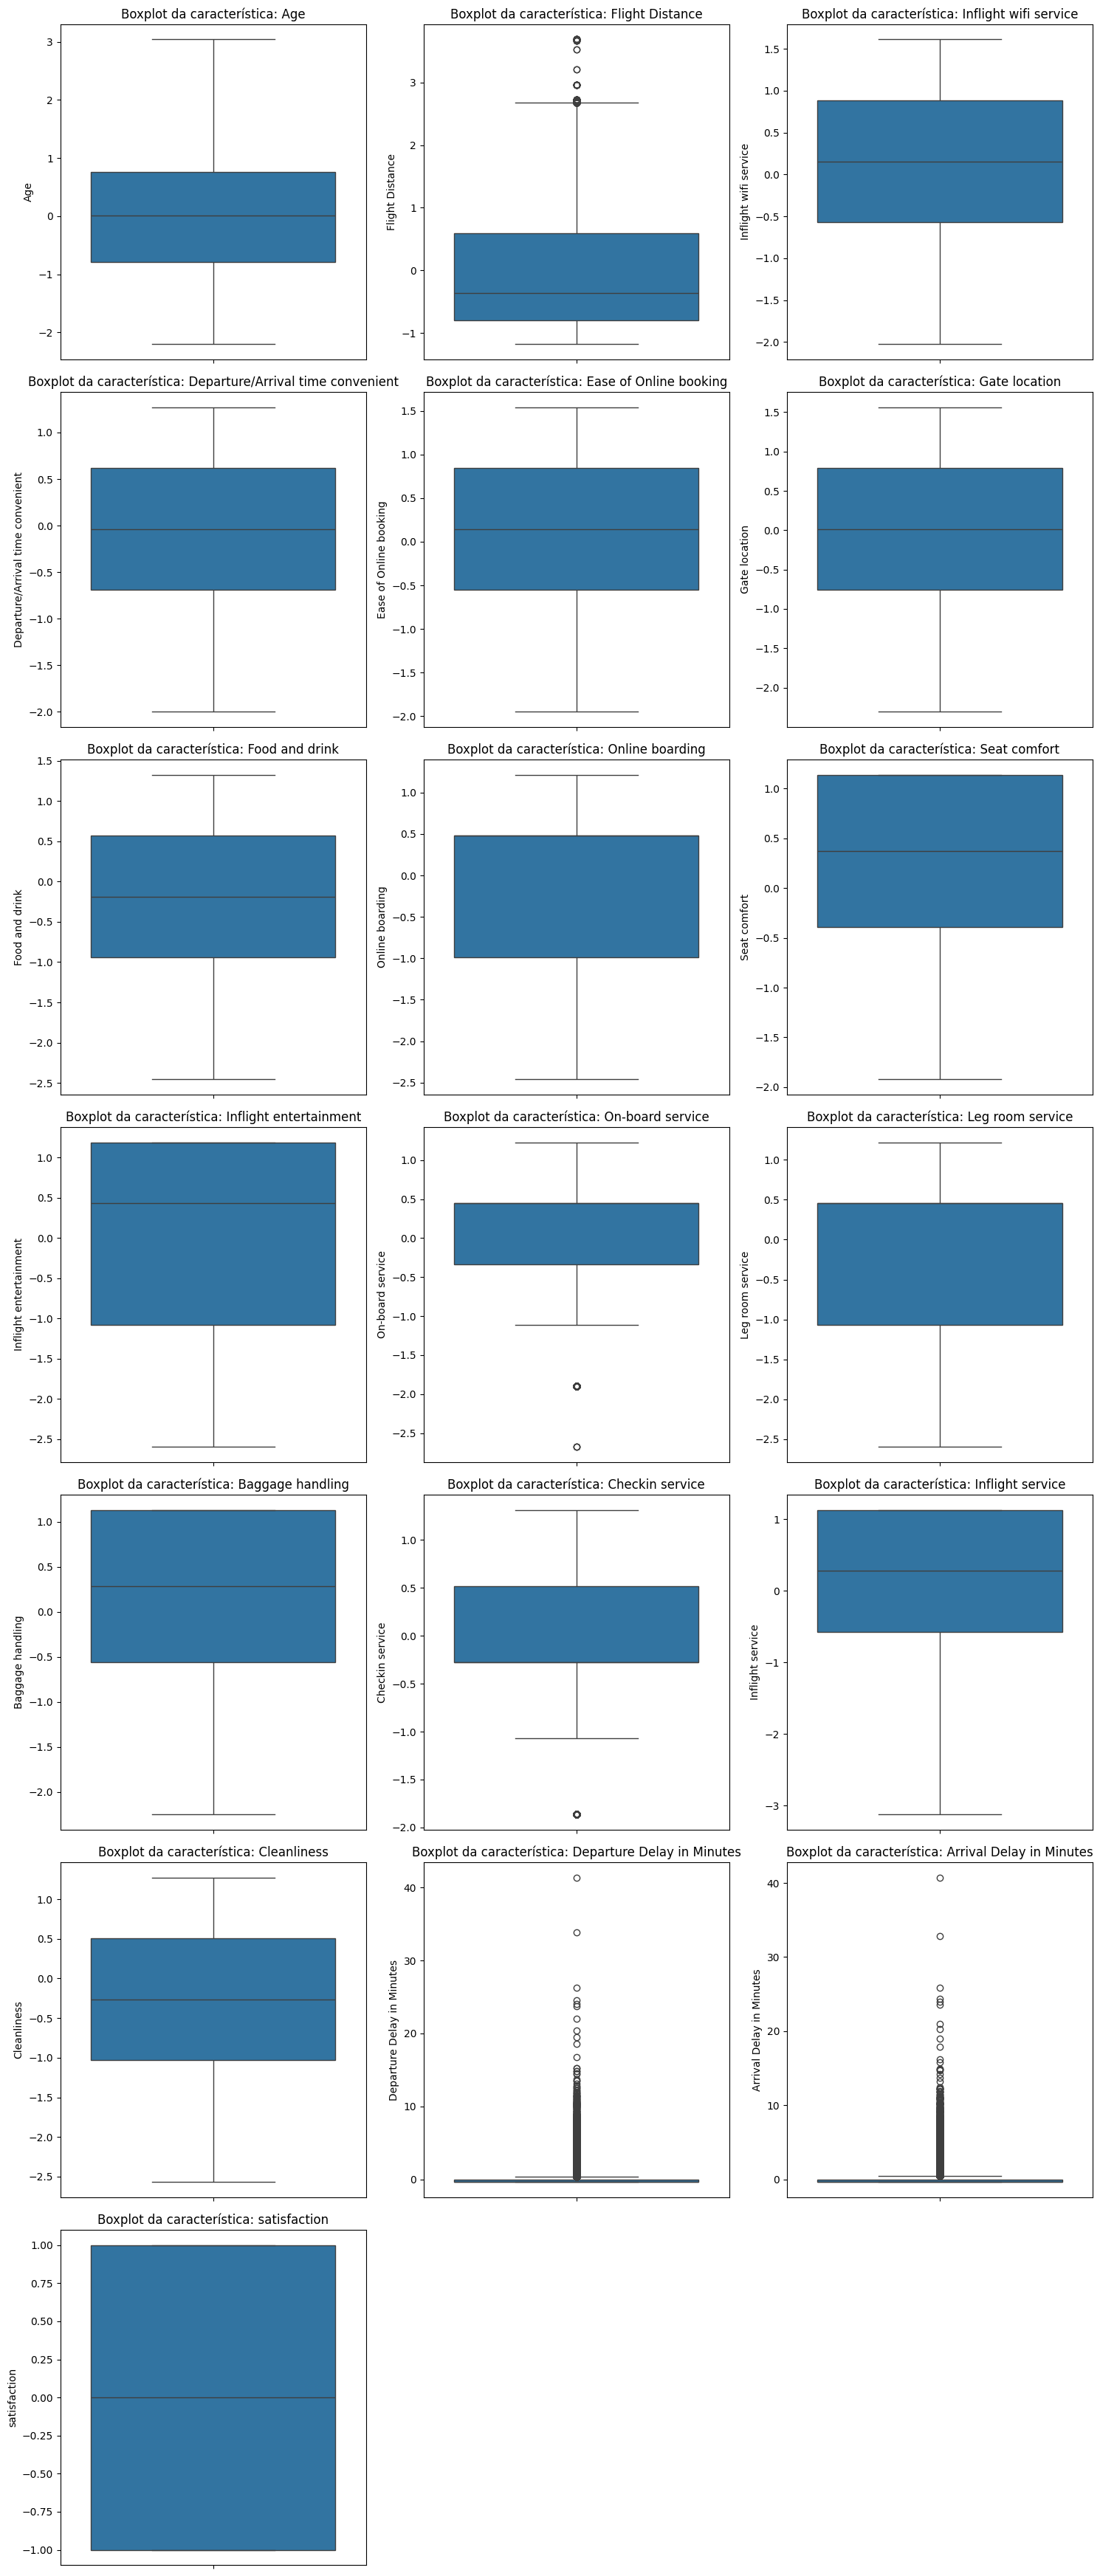

In [8]:
num_features = len(df_scaled.columns)

# Definindo o número de colunas no grid
num_cols = 3
num_rows = (num_features + num_cols - 1) // num_cols  # Calcula o número de linhas

plt.figure(figsize=(num_cols * 5, num_rows * 5))

for i, col in enumerate(df_scaled.columns):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.boxplot(y=df_scaled[col])  # Usando eixo y para mostrar a distribuição
    plt.title(f'Boxplot da característica: {col}')
    plt.ylabel(col)

plt.tight_layout()
plt.show()

Percebemos que apenas algumas colunas apresentam outliers, são elas: Flight Distance, On-board service, Checkin service, Derparture Delay in Minutes e Arrival Delay in Minutes

In [9]:
print(df_scaled[['Departure Delay in Minutes', 'Arrival Delay in Minutes']].describe())


       Departure Delay in Minutes  Arrival Delay in Minutes
count                7.345200e+04              7.345200e+04
mean                -6.964967e-18              3.443789e-17
std                  1.000007e+00              1.000007e+00
min                 -3.811604e-01             -3.861998e-01
25%                 -3.811604e-01             -3.861998e-01
50%                 -3.811604e-01             -3.861998e-01
75%                 -6.644452e-02             -4.876936e-02
max                  4.137115e+01              4.072840e+01


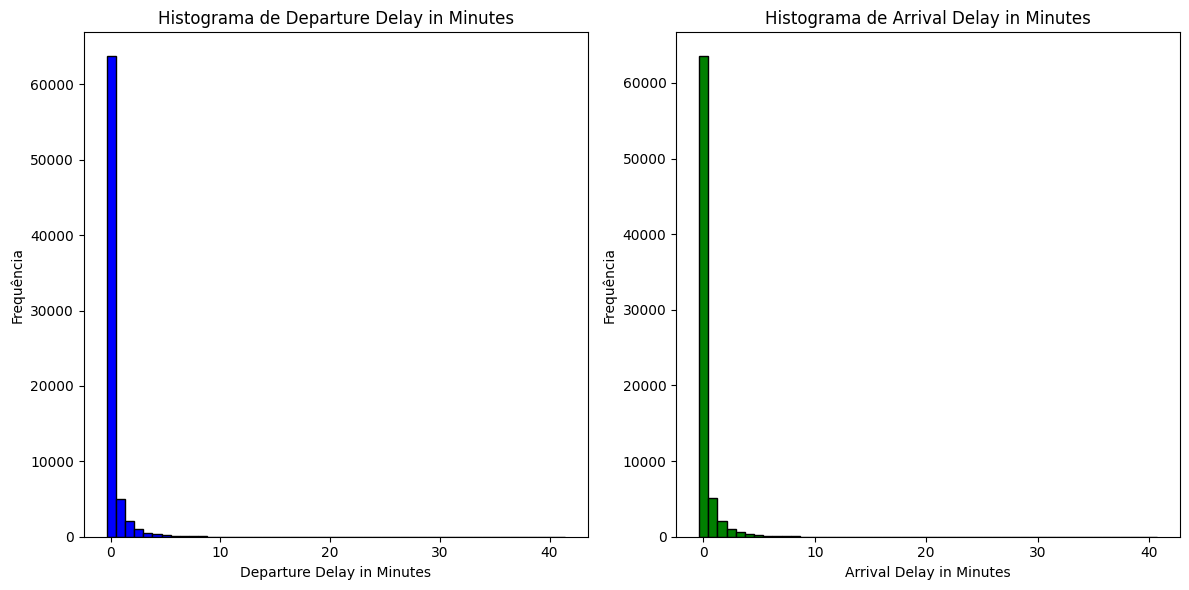

In [10]:
plt.figure(figsize=(12, 6))

# Histograma para Departure Delay
plt.subplot(1, 2, 1)
plt.hist(df_scaled['Departure Delay in Minutes'], bins=50, color='blue', edgecolor='black')
plt.title('Histograma de Departure Delay in Minutes')
plt.xlabel('Departure Delay in Minutes')
plt.ylabel('Frequência')

# Histograma para Arrival Delay
plt.subplot(1, 2, 2)
plt.hist(df_scaled['Arrival Delay in Minutes'], bins=50, color='green', edgecolor='black')
plt.title('Histograma de Arrival Delay in Minutes')
plt.xlabel('Arrival Delay in Minutes')
plt.ylabel('Frequência')

plt.tight_layout()
plt.show()


Achando o melhor número para eps do DBSCAN

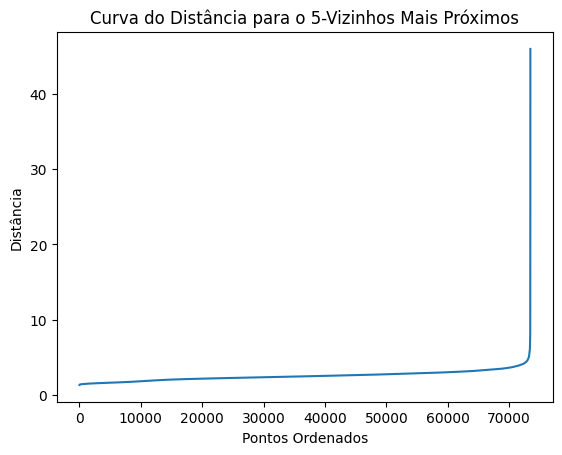

In [11]:
# Calculando distâncias dos k-vizinhos mais próximos
neighbors = NearestNeighbors(n_neighbors=100) # n_neighbors = min_samples
neighbors_fit = neighbors.fit(num_data_scaled)

distances, indices = neighbors_fit.kneighbors(num_data_scaled)
distances = np.sort(distances[:, -1], axis=0)

plt.plot(distances)
plt.title('Curva do Distância para o 5-Vizinhos Mais Próximos')
plt.xlabel('Pontos Ordenados')
plt.ylabel('Distância')
plt.show()

Usando o DBSCAN para achar os outliers

In [14]:
def objective(trial):
    eps = trial.suggest_float('eps', 5, 15) 
    min_samples = trial.suggest_int('min_samples', 100, 500)
    
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(num_data_scaled)
    
    num_outliers = np.sum(labels == -1)
    
    # Penaliza se não houver clusters identificados
    if np.unique(labels).size <= 1:
        return float('inf')  # Penaliza clusters sem ou apenas com outliers
    
    # Calcula o silhouette_score para clusters identificados (se houver)
    try:
        silhouette_avg = silhouette_score(num_data_scaled, labels)
    except ValueError:
        silhouette_avg = -1
    
    return num_outliers - silhouette_avg  # Maximiza o número de outliers enquanto penaliza clusters de baixa qualidade

In [15]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

[I 2024-07-19 00:05:43,269] A new study created in memory with name: no-name-afebf8cf-1aca-4cfb-827a-74575ea17176


In [ ]:
print('Melhores parâmetros encontrados:')
print(study.best_params)

In [ ]:
best_params = study.best_params

dbscan = DBSCAN(eps=best_params['eps'], min_samples=best_params['min_samples'])
labels = dbscan.fit_predict(num_data_scaled)
outliers = np.where(labels == -1)[0]
print("Número de outliers:", len(outliers))

In [ ]:
'''dbscan = DBSCAN(eps=4, min_samples=300)
dbscan.fit(num_data_scaled)

labels = dbscan.labels_
outliers = np.where(labels == -1)[0]
print("Number of outliers:", len(outliers))'''

Number of outliers: 457


In [ ]:
mask = np.isin(df_train.index, outliers, invert=True)
df_cleaned = df_train[mask]
#print("Número de amostras removidas: " + str(df_scaled.shape[0] - df_train.shape[0]))
print(f"Número de amostras antes da remoção dos outliers: {len(df_train)}")
print(f"Número de amostras após a remoção dos outliers: {len(df_cleaned)}")

Número de amostras antes da remoção dos outliers: 73452
Número de amostras após a remoção dos outliers: 72995


Text(0.5, 1.0, 'Boxplot Antes da Remoção de Outliers')

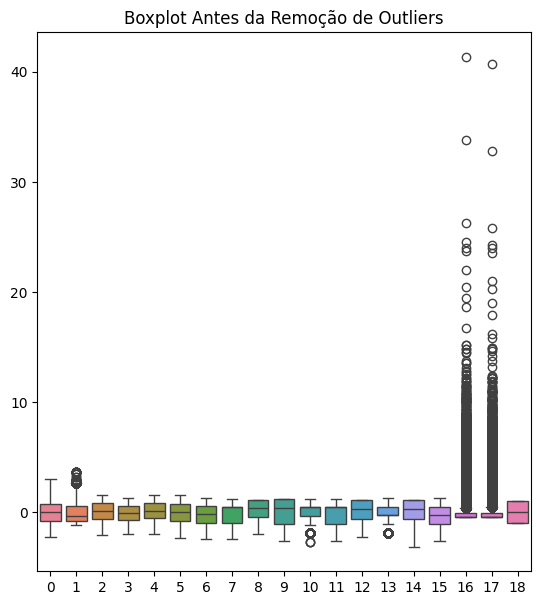

In [ ]:
# Gráfico antes da remoção
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
sns.boxplot(data=num_data_scaled)
plt.title('Boxplot Antes da Remoção de Outliers')

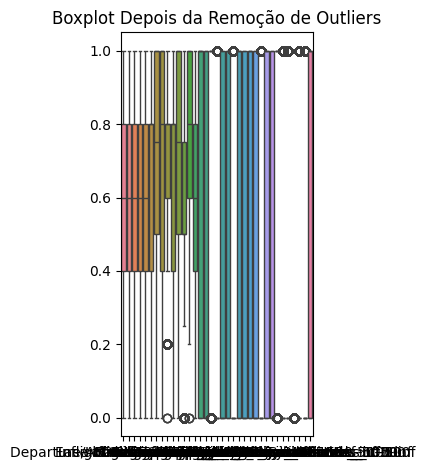

In [ ]:
# Boxplots depois da remoção
plt.subplot(1, 2, 2)
sns.boxplot(data=df_cleaned)
plt.title('Boxplot Depois da Remoção de Outliers')

plt.tight_layout()
plt.show()

In [1]:
num_features = len(df_cleaned.columns)

# Definindo o número de colunas no grid
num_cols = 3
num_rows = (num_features + num_cols - 1) // num_cols  # Calcula o número de linhas

plt.figure(figsize=(num_cols * 5, num_rows * 5))

for i, col in enumerate(df_cleaned.columns):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.boxplot(y=df_cleaned[col])  # Usando eixo y para mostrar a distribuição
    plt.title(f'Boxplot da característica: {col}')
    plt.ylabel(col)

plt.tight_layout()
plt.show()

NameError: name 'df_cleaned' is not defined

##### Discretização das variáveis

Analisando a distribuição das variáveis de acordo com a variável de saída

In [ ]:
def plot_correlation(df: pd.DataFrame, Y_label: str, x_label: str, bin_size: int = 50) -> None:
    plt.figure(figsize=(12, 7))
    
    # Convert x_label to categorical bins
    bin_edges = range(int(df[x_label].min()), int(df[x_label].max()) + bin_size, bin_size)
    bins = pd.cut(df[x_label], bins=bin_edges)
    
    # Create a pivot table with counts of Y_label for each bin of x_label
    pivot_table = df.pivot_table(index=bins, columns=Y_label, aggfunc='size', fill_value=0, observed=False)
    
    # Reset index to turn bins into a column
    pivot_table = pivot_table.reset_index()
    
    # Rename columns for easier access
    pivot_table.columns.name = None
    pivot_table.columns = [x_label, 'Y_0 (unsatisfied)', 'Y_1 (satisfied)']
    
    # Plot using seaborn
    pivot_table_melted = pivot_table.melt(id_vars=x_label, value_vars=['Y_0 (unsatisfied)', 'Y_1 (satisfied)'], 
                                          var_name=Y_label, value_name='count')
    sns.barplot(data=pivot_table_melted, x=x_label, y='count', hue=Y_label)
    
    plt.xlabel(x_label)
    plt.ylabel('Contagem')
    plt.title(f'Contagem de {Y_label} para cada faixa de {x_label}')
    plt.legend(title=Y_label)
    plt.xticks(rotation=45, ha='right')

    plt.show()

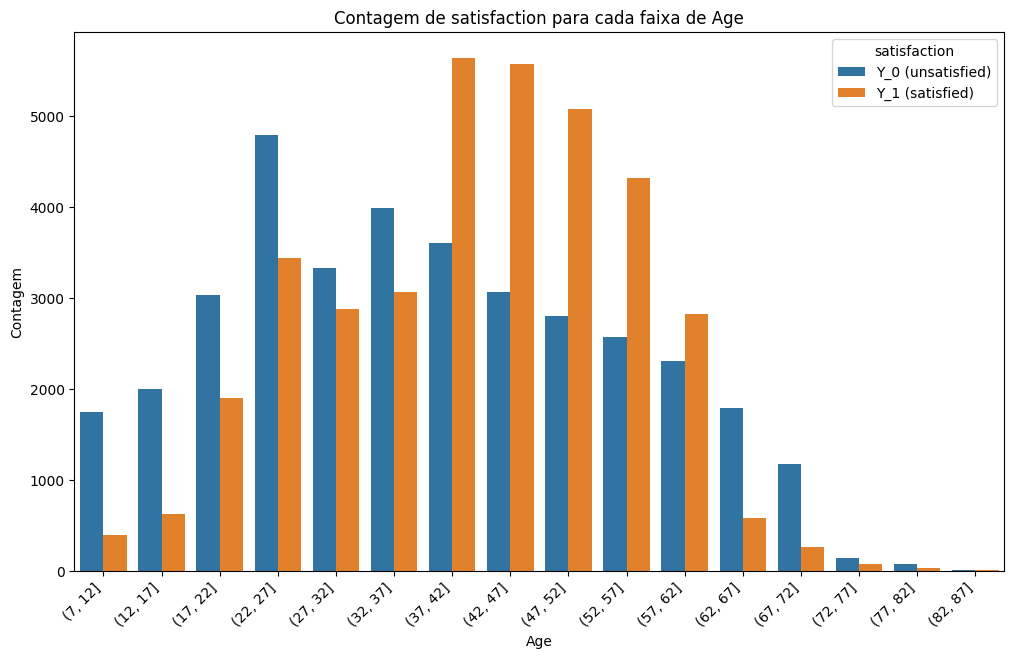

In [ ]:
plot_correlation(df_train, 'satisfaction', 'Age', bin_size=5)

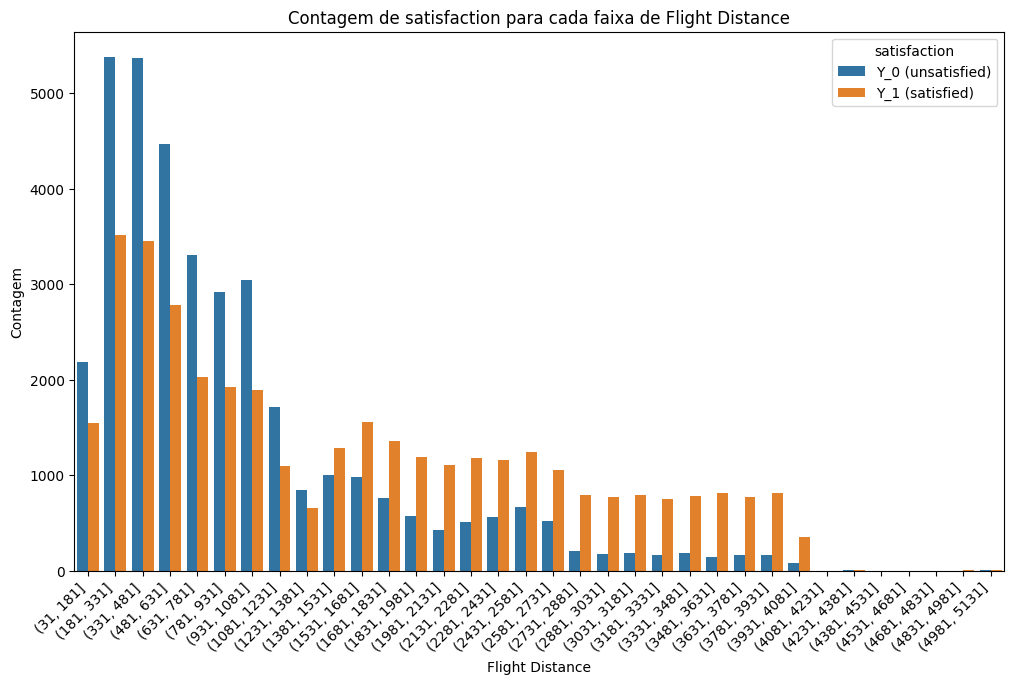

In [ ]:
plot_correlation(df_train, 'satisfaction', 'Flight Distance', bin_size=150)

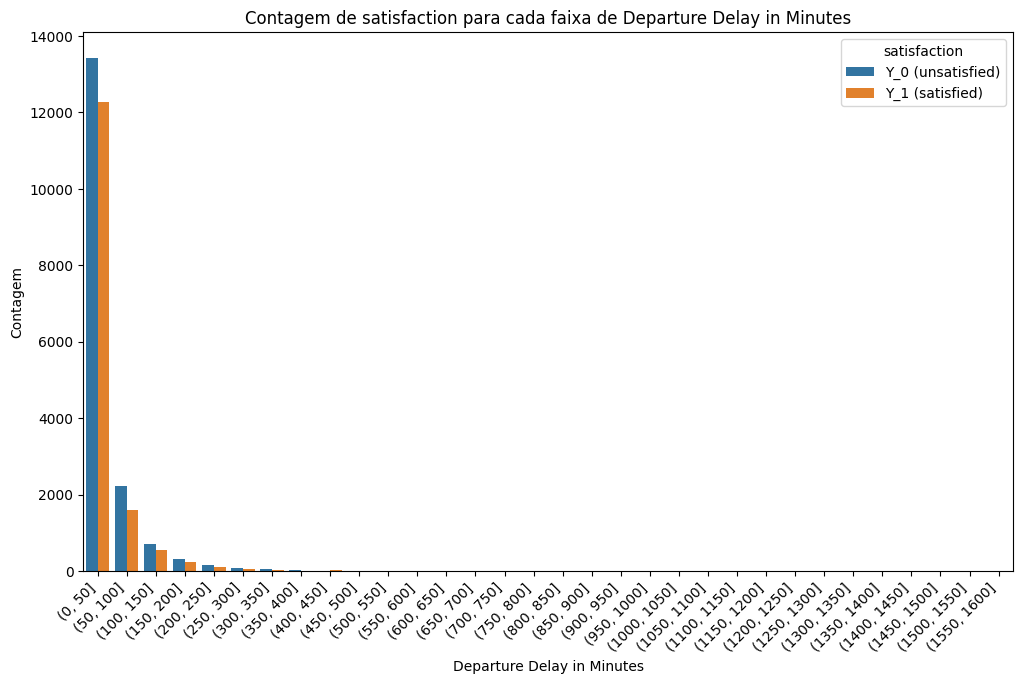

In [ ]:
plot_correlation(df_train, 'satisfaction', 'Departure Delay in Minutes', bin_size=50)

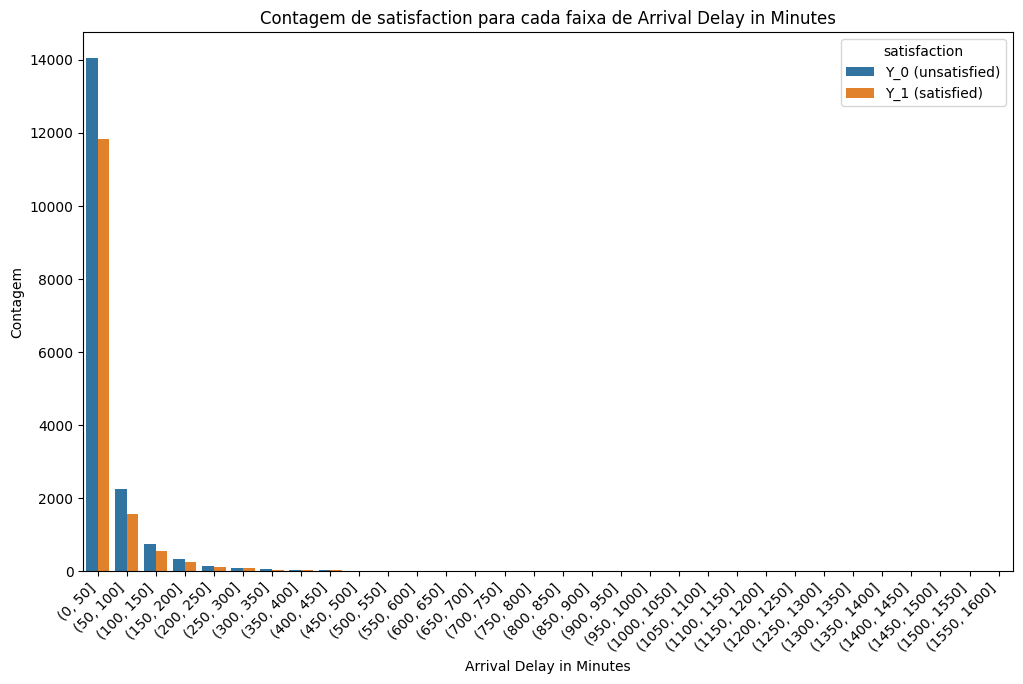

In [ ]:
plot_correlation(df_train, 'satisfaction', 'Arrival Delay in Minutes', bin_size=50)

Discretizando as Variáveis

In [ ]:
def discretize_col(
        df_train: pd.DataFrame, df_val: pd.DataFrame, df_test: pd.DataFrame, 
        col: str, interval: list) -> list[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    
    interval = [-np.inf] + interval + [np.inf]
    labels = [f'{interval[i]}-{interval[i+1]}' for i in range(len(interval) - 1)]
    df_train[col] = pd.cut(df_train[col], bins=interval, labels=labels)
    df_val[col] = pd.cut(df_val[col], bins=interval, labels=labels)
    df_test[col] = pd.cut(df_test[col], bins=interval, labels=labels)

    return df_train, df_val, df_test

In [ ]:
df_train, df_val, df_test = discretize_col(
    df_train=df_train, df_val=df_val, df_test=df_test, col='Age', interval=[37, 62]
)
df_train, df_val, df_test = discretize_col(
    df_train=df_train, df_val=df_val, df_test=df_test, col='Flight Distance', interval=[1550]
)
df_train, df_val, df_test = discretize_col(
    df_train=df_train, df_val=df_val, df_test=df_test, col='Departure Delay in Minutes', interval=[50, 100]
)
df_train, df_val, df_test = discretize_col(
    df_train=df_train, df_val=df_val, df_test=df_test, col='Arrival Delay in Minutes', interval=[50, 100]
)

In [ ]:
df_train.head()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,Male,Loyal Customer,37-62,Business travel,Business,1550-inf,2,1,1,1,...,2,2,2,2,1,2,2,-inf-50,-inf-50,0
1,Male,Loyal Customer,37-62,Business travel,Business,1550-inf,2,1,1,1,...,2,2,2,2,4,2,3,-inf-50,-inf-50,0
2,Female,Loyal Customer,37-62,Business travel,Business,-inf-1550,3,3,3,3,...,2,2,2,2,5,2,3,-inf-50,-inf-50,1
3,Female,Loyal Customer,37-62,Business travel,Business,-inf-1550,5,5,5,5,...,2,2,2,2,3,2,5,-inf-50,-inf-50,1
4,Female,Loyal Customer,-inf-37,Business travel,Business,1550-inf,4,4,5,4,...,4,4,4,4,4,4,5,-inf-50,-inf-50,1


##### Transformando as variáveis categóricas em One-hot-encoding

In [ ]:
def one_hot_encoding(df_train: pd.DataFrame, df_test: pd.DataFrame, df_val: pd.DataFrame) -> list[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    categorical_columns = df_train.select_dtypes(include=['object', 'category']).columns
    one_hot_df_train = pd.get_dummies(df_train, columns=categorical_columns, dtype=int)

    train_columns = one_hot_df_train.columns

    one_hot_df_val = pd.get_dummies(df_val, columns=categorical_columns, dtype=int)
    one_hot_df_test = pd.get_dummies(df_test, columns=categorical_columns, dtype=int)
    for col in train_columns:
        if col not in one_hot_df_val:
            one_hot_df_val[col] = 0
        if col not in one_hot_df_test:
            one_hot_df_test[col] = 0
    one_hot_df_val = one_hot_df_val[train_columns]
    one_hot_df_test = one_hot_df_test[train_columns]

    return one_hot_df_train, one_hot_df_val, one_hot_df_test

In [ ]:
df_train, df_val, df_test = one_hot_encoding(df_train=df_train, df_val=df_val, df_test=df_test)

In [ ]:
df_train.columns

Index(['Inflight wifi service', 'Departure/Arrival time convenient',
       'Ease of Online booking', 'Gate location', 'Food and drink',
       'Online boarding', 'Seat comfort', 'Inflight entertainment',
       'On-board service', 'Leg room service', 'Baggage handling',
       'Checkin service', 'Inflight service', 'Cleanliness', 'satisfaction',
       'Gender_Female', 'Gender_Male', 'Customer Type_Loyal Customer',
       'Customer Type_disloyal Customer', 'Age_-inf-37', 'Age_37-62',
       'Age_62-inf', 'Type of Travel_Business travel',
       'Type of Travel_Personal Travel', 'Class_Business', 'Class_Eco',
       'Class_Eco Plus', 'Flight Distance_-inf-1550',
       'Flight Distance_1550-inf', 'Departure Delay in Minutes_-inf-50',
       'Departure Delay in Minutes_50-100',
       'Departure Delay in Minutes_100-inf',
       'Arrival Delay in Minutes_-inf-50', 'Arrival Delay in Minutes_50-100',
       'Arrival Delay in Minutes_100-inf'],
      dtype='object')

#### Normalização dos Dados

In [ ]:
columns_to_normalize = [
    'Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking',
    'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
    'Inflight entertainment', 'On-board service', 'Leg room service',
    'Baggage handling', 'Checkin service', 'Inflight service', 'Cleanliness'
]

In [ ]:
scaler = MinMaxScaler()

In [ ]:
scaler.fit(df_train[columns_to_normalize])

MinMaxScaler()

In [ ]:
df_train[columns_to_normalize] = scaler.transform(df_train[columns_to_normalize])
df_val[columns_to_normalize] = scaler.transform(df_val[columns_to_normalize])
df_test[columns_to_normalize] = scaler.transform(df_test[columns_to_normalize])

In [ ]:
df_train = pd.DataFrame(df_train)
df_val = pd.DataFrame(df_val)
df_test = pd.DataFrame(df_test)

In [ ]:
df_train.head()

,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,...,Class_Eco,Class_Eco Plus,Flight Distance_-inf-1550,Flight Distance_1550-inf,Departure Delay in Minutes_-inf-50,Departure Delay in Minutes_50-100,Departure Delay in Minutes_100-inf,Arrival Delay in Minutes_-inf-50,Arrival Delay in Minutes_50-100,Arrival Delay in Minutes_100-inf
0,0.4,0.2,0.2,0.2,0.4,0.6,0.75,0.4,0.4,0.4,...,0,0,0,1,1,0,0,1,0,0
1,0.4,0.2,0.2,0.2,0.2,0.6,0.75,0.4,0.4,0.4,...,0,0,0,1,1,0,0,1,0,0
2,0.6,0.6,0.6,0.6,0.6,1.0,1.00,0.4,0.4,0.4,...,0,0,1,0,1,0,0,1,0,0
3,1.0,1.0,1.0,1.0,0.6,1.0,1.00,0.4,0.4,0.4,...,0,0,1,0,1,0,0,1,0,0
4,0.8,0.8,1.0,0.8,1.0,0.8,0.75,0.8,0.8,0.8,...,0,0,0,1,1,0,0,1,0,0


##### Reordenando o Dataframe para a variável de saída ficar no final

In [ ]:
cols = list(df_train.columns)
cols.remove('satisfaction')
cols.append('satisfaction')

df_train = df_train[cols]
df_val = df_val[cols]
df_test = df_test[cols]

##### Salvando o modelo

In [ ]:
df_train.to_csv('../data/treated_data/train.csv', index=False)
df_val.to_csv('../data/treated_data/validation.csv', index=False)
df_test.to_csv('../data/treated_data/test.csv', index=False)